In [1]:
 ## pycrime: python implementation of ring-down data analysi for the C.Ri.Me. laboratory
    ## G. Vajente (gvajente@ligo.caltech.edu) 2017-10-13
    ## edited - S.Tait (s.tait.1@LIGO.ORG) 2019-11-19
    ##Fit all modes of a ring-down measurement, using a model tuned for circular samples 
    ## (almost degenerate doublet modes).
import matplotlib.pyplot as plt
from numpy import *
import warnings 
warnings.filterwarnings('ignore')
import numpy
import matplotlib
matplotlib.use("Agg")
from pylab import *
import os
from IPython import display
import scipy
import time
from scipy.signal import *
import pickle
import sys
import scipy.io as sio 
import hdf5storage
#%matplotlib notebook


def residual_check(a,T,fun3,p_diffq):
    # check to see if the residuals are more than 0.1 - hints not great fit 
    # if > 0.1 returns 0 : bad fit, 1 : good fit 
    if sum(a - fun3(T, p_diffq))>0.3 :
        check = 0
    else: 
        check = 1
    return check

def goodAmps(pp):
    # check to see if the ringdown is exponential or beating
    # defines wheather both sets of Qs should be used or just one 
    if pp[1] < 0.001 :
        #if second amplitude is less than zero - ringdown highly exponential: only use Q1 
        check = 0 
    else: 
        #else beating - use Q1 and Q2 
        check = 1 
    return check

makeplot = True 
verbose = False 

prefix = "/Users/igradmin/Dropbox/MATLAB/Testing_Grounds/MatBeat/Data/300 degree HT/FullStack 300/Prebeat_ReAnalysis_MKH_FullSus9"




In [2]:
os.path.sep

'/'

In [10]:
def fit_ringdowns_degenerate_st(prefix, makeplot=True, verbose=False):
    """
    
    ## pycrime: python implementation of ring-down data analysi for the C.Ri.Me. laboratory
    ## G. Vajente (gvajente@ligo.caltech.edu) 2017-10-13
    ## edited - S.Tait (s.tait.1@LIGO.ORG) 2019-11-19
    Fit all modes of a ring-down measurement, using a model tuned for circular samples 
    (almost degenerate doublet modes).
    
    Inputs:
        freqs    = list of frequencies
        modes    = list of mode identifications
        T        = time vector
        RX       = Amplitude data for ringdown measurements 
        ia       = indeces of good times
        prefix   = where results will be saved
        makeplot = whether to make a plot
        verbose  = print fitting statistics
    Outputs:
        freqs    = list of frequencies with good measurements of Q values
        q        = Q values for each frequency (rows) and mode in a doublet (columns)
        q_ci     = 95% confidence intervals, one mode per row [Q1_min, Q1_max, Q2_min, Q2_max] 
        df       = frequency splitting of the modes
        df_ci    = 95% confidence interval for the ferquency splitting
    """

    ## loop over all frequencies
    
    matdata = hdf5storage.loadmat(prefix + os.path.sep + 'PyTotalAnalysis.mat')
    #matdata = sio.loadmat(prefix +'/PyTotalAnalysis.mat')
    freqs = matdata['freq']
    modes = matdata['modes']
    q     = zeros((len(freqs), 2))
    q_ci  = zeros((len(freqs), 4))
    df    = zeros((len(freqs), 1))
    df_ci = zeros((len(freqs), 2))

    
    for i in range(len(freqs)):
        #matdata = sio.loadmat(prefix +'/PyTotalAnalysis.mat')
        matdata = hdf5storage.loadmat(prefix + os.path.sep + 'PyTotalAnalysis.mat')
        modes = matdata['modes']
        T     = matdata['ring_times']
        RX    = matdata['ring_amps']
        ia    = matdata['ia']
        
        T = T[~isnan(T.T[i])]
        T = T.T[i]

        RX = RX[~isnan(RX.T[i])]
        RX = RX.T[i]
        
        ia = ia[~isnan(ia.T[i])]
        ia = ia.T[i] 
        ia =(ia>0)
        RY = zeros(shape(RX))
        ia = ones(shape(RX))
        
        ia = ia.T 
        ia =(ia>0)
    
        if verbose:
            print('    (%d) f = %.0f Hz' % (i, freqs[i]))
            
        a= RX 
        a = a / a[0]

        # just in case we need to select a subset of the data points
        ii = logical_and(T>0, ia)
        
        ### The ringdown model for degenerate modes is highly non linear, so
        ### we first need a very good guess for the starting point
        
        # first fit a simple exponential
        from scipy.optimize import minimize
        fun = lambda p,t: p[0]*exp(-abs(p[1]) * t) + abs(p[2])
        err = lambda p: mean((fun(p, T[ii]) - a[ii])**2)
        p0 = [a[0], 0, 0]
        res = minimize(err, p0, method='BFGS')
        res = minimize(err, res.x, method='Nelder-Mead')
        p = res.x
        err_simple = res.fun
        
        tau0 = abs(p[1]) # initial guess for the mean time constant
        a_mean = p[0]     # initial guess for the mean amplitude, estimated from the fit
        
        # subtract the mean exponential and estimate beat amplitude
        aa = a[ii] - fun(p, T[ii])
        da = (amax(aa) - amin(aa)) / 2
        
        
        # initial amplitude offset
        oa = (amax(aa) + amin(aa)) / 2
        a_max = a_mean + oa   # estimate of maximum amplitude
        
        # find beat frequency as the maximum of PSD of residual
        np = 256
        b = 0
        aa = a - fun(p,T)
       
        ## add buffer for FFT calculation if data is shorter than nperseg =256 

        if len(aa)<np: 
            aa_buffered = concatenate([aa,zeros(shape(aa)),zeros(shape(aa))])
        else:
            aa_buffered = aa
            
        #print(len(aa_buffered))
        while (b == 0 and np<len(aa_buffered)):
            # use only four times the decay time, to improve SNR of beat peak,
            # if we have enough data
            if 4/tau0 > np/2:
                fr, ss = welch(aa_buffered[T<4/tau0], 1.0/(T[1]-T[0]), nperseg=np, detrend='linear', axis=0)
            else:
                fr, ss = welch(aa_buffered, 1.0/(T[1]-T[0]), nperseg=np, detrend='linear', axis=0)
            # find the most prominent peak
            b = argmax(ss[1:])
            # double number of points and repeat if the peak is still in the first bin
            np = 2*np
        fbeat = fr[b+1]   # estimate of beat frequency
        
        
       # plt.figure()
       # plt.grid()
       # plt.title('FFT')
       # plt.plot(fr,ss,label ='Inital f_beat estimate')
       # plt.legend()
        

        # to estimate the initial phase, fit a cosine to four periods
        
        i0 = logical_and(T < amin(T[ia]) + 4/fbeat, ia)
        fun1 = lambda p,t: abs(p[0]) * cos(2*pi*p[1]*t + p[2]) + p[3]
        err1 = lambda p: mean((fun1(p,T[i0]) - aa[i0])**2)
        
        
        # initial phase for the the fit is important, so we try a few and
        # see which one gives the best fit
        pp0 = array([[da/2, fbeat, 0,mean(aa[i0])],[da/2, fbeat, pi/2,mean(aa[i0])],[da/2, fbeat, pi,mean(aa[i0])],[da/2, fbeat, 3*pi/2, mean(aa[i0])]])
        pp = zeros(pp0.shape)
        e = zeros(pp0.shape[0])
        for k in range(len(pp0)):
            res = minimize(err1, pp0[k], method='Nelder-Mead')
            res = minimize(err1, res.x, method='BFGS')
            pp[k,:] = res.x
            e[k] = res.fun
        pp = pp[argmin(e),:]
        phi0 = pp[2]  # initial estimate of phase
        fbeat = pp[1]  # refine beat frequency
        
        #plt.figure()
        #plt.grid()
        
        #plt.plot(linspace(0,10000),fun1(e,linspace(0,10000)))
        #plt.title('4 period - Detrended Signal fbeat : %.3f'%(fbeat))
        
        ### Now we can go for the real fit. We first fit a reduced model,
        ### forcing the Q of the two degenarte modes to be the same. Then we
        ### use the result as starting point for a fit that allows the two Q
        ### to be different. At the end we choose which model to use
        
        # select the right time range: use only 4 times the decay time, and remove spikes due to autocentering
        ii = logical_and(T < min(T[ia]) + 4/tau0, ia) 
        
        # fit a reduced model, same Q values for both modes to improve the initial guess
        fun2 = lambda t,p: sqrt((p[0]*exp(-abs(p[2])*t)*sqrt(1 + p[1]**2 + 2*p[1]*cos(p[3]*t+p[4])))**2 + p[5]**2)
        err2 = lambda p: mean((fun2(T[ii],p) - a[ii])**2)
        # initial point for the fit, from the previous guesses
        #    max.ampl, mod.depth, mean tau, freq. diff., phase, background
        p0 = [a_max, da, tau0, 2*pi*fbeat, phi0, 0];
        # fit a couple of times. 'BFGS' is good to get to the solution, but
        # sometimes it gets stuck and 'Nelder-Mead' is good to get out of local
        # minima
        if verbose:
            print('        reduced model: initial residual = %g' % err2(p0))
        res = minimize(err2, p0, method='Nelder-Mead')
        e0 = res.fun
        res = minimize(err2, res.x, method='BFGS')
        e1 = res.fun
        if verbose:
            print('        reduced model: residual = %g' % e1)
        # repeat the refinement iteratively, as long as we can get better residual
        while e1<e0:
            e0 = e1
            res = minimize(err2, res.x, method='Nelder-Mead')
            res = minimize(err2, res.x, method='BFGS')
            e1 = res.fun
            if verbose:
                print('        reduced model: residual = %g' % e1)  
        # save results of reduced model fit
        err_sameq = res.fun
        p_sameq = res.x
        p_sameq[2] = abs(p_sameq[2])    # force positive Q as in the fit function
        
        # fit using curve_fit, to get coefficient error estimates
        from scipy.optimize import curve_fit
        fun2b = lambda t,p0,p1,p2,p3,p4,p5: sqrt((p0*exp(-abs(p2)*t)                                                 *sqrt(1 + p1**2 + 2*p1*cos(p3*t+p4)))**2 + p5**2)
        try:
            p_sameq, pcov_sameq = curve_fit(fun2b, T[ii], a[ii], p_sameq)
            p_sameq[2] = abs(p_sameq[2])  # force positive Q as in the fit function
            err_sameq = err2(p_sameq)
            p_err_sameq = sqrt(diag(pcov_sameq))
        
            ### then fit a full model, allowing for different Q values
            fun3 = lambda t,p: sqrt((p[0] * exp(-abs(p[2])*t) * sqrt(1 + p[1]**2 *exp(-2*(abs(p[3])-abs(p[2]))*t) + 2*p[1]*exp(-(abs(p[3])-abs(p[2]))*t)                                    *cos(p[4]*t+p[5])))**2 + p[6]**2)
            err3 = lambda p: mean((fun3(T[ii],p) - a[ii])**2)
            # use the result of the previous fit as starting point
            p0 = [p_sameq[0], p_sameq[1], abs(p_sameq[2]), abs(p_sameq[2]), p_sameq[3], p_sameq[4], p_sameq[5]];
            if verbose:
                print('        full model: initial residual = %g' % err3(p0))
            res = minimize(err3, p0, method='Nelder-Mead')
            e0 = res.fun
            res = minimize(err3, res.x, method='BFGS')
            e1 = res.fun
            if verbose:
                print('        full model: residual = %g' % e1)
            # repeat the refinement iteratively, as long as we can get better residual
            while e1<e0:
                e0 = e1
                res = minimize(err3, res.x, method='Nelder-Mead')
                res = minimize(err3, res.x, method='BFGS')
                e1 = res.fun
                if verbose:
                    print('        full model: residual = %g' % e1)  
            # extract fit results
            p_diffq = res.x
            p_diffq[2] = abs(p_diffq[2]) # force positive Q as in the fit function
            p_diffq[3] = abs(p_diffq[3])
            err_diffq = res.fun
        
            # fit using curve_fit, to get coefficient error estimates
            fun3b = lambda t,p0,p1,p2,p3,p4,p5,p6: sqrt((p0 * exp(-abs(p2)*t) * sqrt(1 + p1**2*exp(-2*(abs(p3)-abs(p2))*t) + 2*p1*exp(-(abs(p3)-abs(p2))*t)*cos(p4*t+p5)))**2 + p6**2)
            p_diffq, pcov_diffq = curve_fit(fun3b, T[ii], a[ii], p_diffq)
            p_diffq[2] = abs(p_diffq[2]) # force positive Q as in the fit function
            p_diffq[3] = abs(p_diffq[3])
            err_diffq = err3(p_diffq)
            p_err_diffq = sqrt(diag(pcov_diffq))
        except: 
            print("dF FITTING ERROR: max number of itterations reached ")
            
            print("please fit ringdown %d manually", i)
            continue 
            ### check if allowing different Q improved significantly the residual
#        if err_diffq/err_sameq < 0.5:
        if 1 ==1:
            # the fit with different Q is significantly better, use it

            # compute 95% (2 sigma) intervals
            p_err = sqrt(diag(pcov_diffq))
            ci = c_[p_diffq-2*p_err, p_diffq+2*p_err]
            # compute the two Q values
            q[i,0] = pi*freqs[i]/p_diffq[2]
            q[i,1] = pi*freqs[i]/p_diffq[3]
            # and corresponding confidence intervals
            dfr = 0.5 # Error on frequency estimation
            q_ci[i,0] = pi*(freqs[i] - dfr)/ ci[2,1]
            q_ci[i,1] = pi*(freqs[i] + dfr)/ ci[2,0]
            q_ci[i,2] = pi*(freqs[i] - dfr)/ ci[3,1]
            q_ci[i,3] = pi*(freqs[i] + dfr)/ ci[3,0]
            
            # compute the beat frequency
            df[i] = p_diffq[4]/2/pi
            df_ci[i,0] = ci[4,0]/2/pi
            df_ci[i,1] = ci[4,1]/2/pi
        else:
            # no significant improvement allowing different Q, fall back to same Q fit
            if verbose:
                print(('        residual with different Q (%g) not significantly better' +                        ' than residual with same Q (%g).\n        Using same Q fit ') %                  (err_diffq, err_sameq))

            # compute 95% (2 sigma) intervals
            p_err = sqrt(diag(pcov_sameq))
            ci = c_[p_sameq-2*p_err, p_sameq+2*p_err]
            # compute the two Q values
            q[i,0] = pi*freqs[i]/p_diffq[2]
            q[i,1] = pi*freqs[i]/p_diffq[2]
            # and corresponding confidence intervals
            dfr = 0.5 # Error on frequency estimation
            q_ci[i,0] = pi*(freqs[i] - dfr)/ ci[2,1]
            q_ci[i,1] = pi*(freqs[i] + dfr)/ ci[2,0]
            q_ci[i,2] = pi*(freqs[i] - dfr)/ ci[2,1]
            q_ci[i,3] = pi*(freqs[i] + dfr)/ ci[2,0]
            
            # compute the beat frequency
            df[i] = p_sameq[3]/2/pi
            df_ci[i,0] = ci[3,0]/2/pi
            df_ci[i,1] = ci[3,1]/2/pi
        
        # make a plot if requested
        if makeplot ==True:
            figure(figsize=(10,8))
            plt.rc('font', size=12)
            subplot2grid((4,1), (0,0), rowspan=3)
            #if err_diffq/err_sameq < 0.5:
            if 1 ==1:
                plot(T[ii], a[ii], '.', T, fun3(T, p_diffq))
                pp = p_diffq
            else:
                plot(T[ii], a[ii], '.', T, fun2(T, p_sameq))
                pp = p_sameq
            #xlabel('Time [s]')
            ylabel('Normallised Amplitude')
            legend(('Data', 'Fit'))
            grid()
            title(('(%d) f_0=%.4f Hz (A_1=%.3f, A_2=%.3f) $\delta$f=%.3f Hz (%.3f:%.3f)\n' +                   '$\phi$_1=%.3e (%.3e:%.3e), $\phi$_2=%.3e (%.3e:%.3e)') %                 (i, freqs[i], pp[0], pp[0]*pp[1], df[i], df_ci[i,0], df_ci[i,1],                  1/q[i,0], 1/q_ci[i,0], 1/q_ci[i,1], 1/q[i,1], 1/q_ci[i,2], 1/q_ci[i,3]))
            xlim([0, amax(T[ii])])
            
          
            subplot2grid((4,1), (3,0), rowspan=1)
#            if err_diffq/err_sameq < 0.5:
            if 1 ==1:
                plot(T[ii], a[ii] - fun3(T[ii], p_diffq), '.')
            else:
                plot(T[ii], a[ii] - fun2(T[ii], p_sameq), '.')
            xlabel('Time [s]')
            ylabel('Residual ')
            grid()
            xlim([0, amax(T[ii])])
            savefig(prefix + os.path.sep +  'fit_%.0f.png' % i )
            #print((i, freqs[i], pp[0], pp[0]*pp[1], df[i], df_ci[i,0], df_ci[i,1],q[i,0], q_ci[i,0], q_ci[i,1], q[i,1], q_ci[i,2], q_ci[i,3]))
            
        sresid = residual_check(a,T,fun3,p_diffq) 
        gamp   = goodAmps(pp)
        
        
        #with open(prefix + '/TESTringdown.pickle', 'a') as p:
        #   X = {'freqs':freqs, 'modes':modes, 'T':T[ii], 'RX':RX[ii], 'RY':RY[ii], 'q':q, 'q_ci':q_ci,
        #    'df':df, 'df_ci':df_ci,'Fit':fun3(T, p_diffq)}
        #    pickle.dump(X, p)
        #    p.close()
        if makeplot ==True:
            with open(prefix +  os.path.sep + 'results_' + prefix.split(os.path.sep)[-1] + '.txt', 'a') as f:
                if i==0:
#                with open(prefix + '/results_' + prefix.split('/')[-1] + '.txt', 'a') as f:
                    f.write('## Freq\t\tloss1\t\tloss2\tLow_Err L1 \tUp_Err L1 \tLow_Err L2\t Up_Err L2\t Loop Number\t\Good Residuals\tUse 2 Qs?\n')
               # f.write('%% Freq\tQ1\tQ2\tQ1_CI\tQ1_CI\tQ2_CI\tQ2_CI\tmode\t\ResCHK\tAmpCHK\n')
                f.write('%.4f\t\t%.4e\t%.4e\t%.4e\t%.4e\t%.4e\t%.4e\t%.0f\t%.0f\t%.0f\n' %                 (freqs[i], 1/q[i,0], 1/q[i,1], 1/q_ci[i,0], 1/q_ci[i,1], 1/q_ci[i,2], 1/q_ci[i,3],i,sresid,gamp))
                f.close()
          
    
    #store all files in a single directory 
    

    # exclude those modes with Q compatible with zero
    idx = where(logical_and(q_ci[:,0]*q_ci[:,1] > 0, q_ci[:,2]*q_ci[:,3] > 0))[0]
    freqs = freqs[idx]
    q = q[idx]
    q_ci = q_ci[idx,:]
    df_ci = df_ci[idx,:]

  # save final results
   
    with open(prefix + os.path.sep + 'ringdown.pickle', 'wb') as f:
        X = {'freqs':freqs, 'modes':modes, 'T':T, 'RX':RX, 'q':q, 'q_ci':q_ci,'df':df, 'df_ci':df_ci}
        pickle.dump(X, f)
        
        
   # with open(prefix + '/results_' + prefix.split('/')[-1] + '.txt', 'w') as f:
   #     f.write('%% Freq\tQ1\tQ2\tQ1_CI\tQ1_CI\tQ2_CI\tQ2_CI\tmode\n')
   #     for i in range(len(freqs)):
   #         f.write('%.1f\t%.4e\t%.4e\t%.4e\t%.4e\t%.4e\t%.4e\n' % \
   #         (freqs[i], q[i,0], q[i,1], q_ci[i,0], q_ci[i,1], q_ci[i,2], q_ci[i,3]))
   #         f.close()
 
        
    
    # make summary plot
    if makeplot == True:
        figure(figsize=(10,8))
        ax = subplot(111)
        ax.errorbar(freqs/1e3, 1/q[:,0], yerr=(1/q_ci[:,1]-1/q_ci[:,0])/2, fmt='.', capsize=5)
        ax.errorbar(freqs/1e3, 1/q[:,1], yerr=(1/q_ci[:,3]-1/q_ci[:,2])/2, fmt='.', capsize=5)
        ax.set_yscale("log", nonposy='clip')
        xlabel('Frequency [kHz]')
        ylabel('Mechanical loss $\phi$')
        grid()
        title('%s %s' % (prefix.split(os.path.sep)[-2], prefix.split(os.path.sep)[-1]))
        savefig(prefix + os.path.sep + 'results_' + prefix.split(os.path.sep)[-1] + '.png')
        
    return freqs, q, q_ci, df, df_ci, aa_buffered




    (0) f = 2823 Hz
        reduced model: initial residual = 0.151117
        reduced model: residual = 0.00210535
        reduced model: residual = 0.00210535
        reduced model: residual = 0.00210535
        full model: initial residual = 0.00210535
        full model: residual = 0.00204595
        full model: residual = 0.00204595


<IPython.core.display.Javascript object>


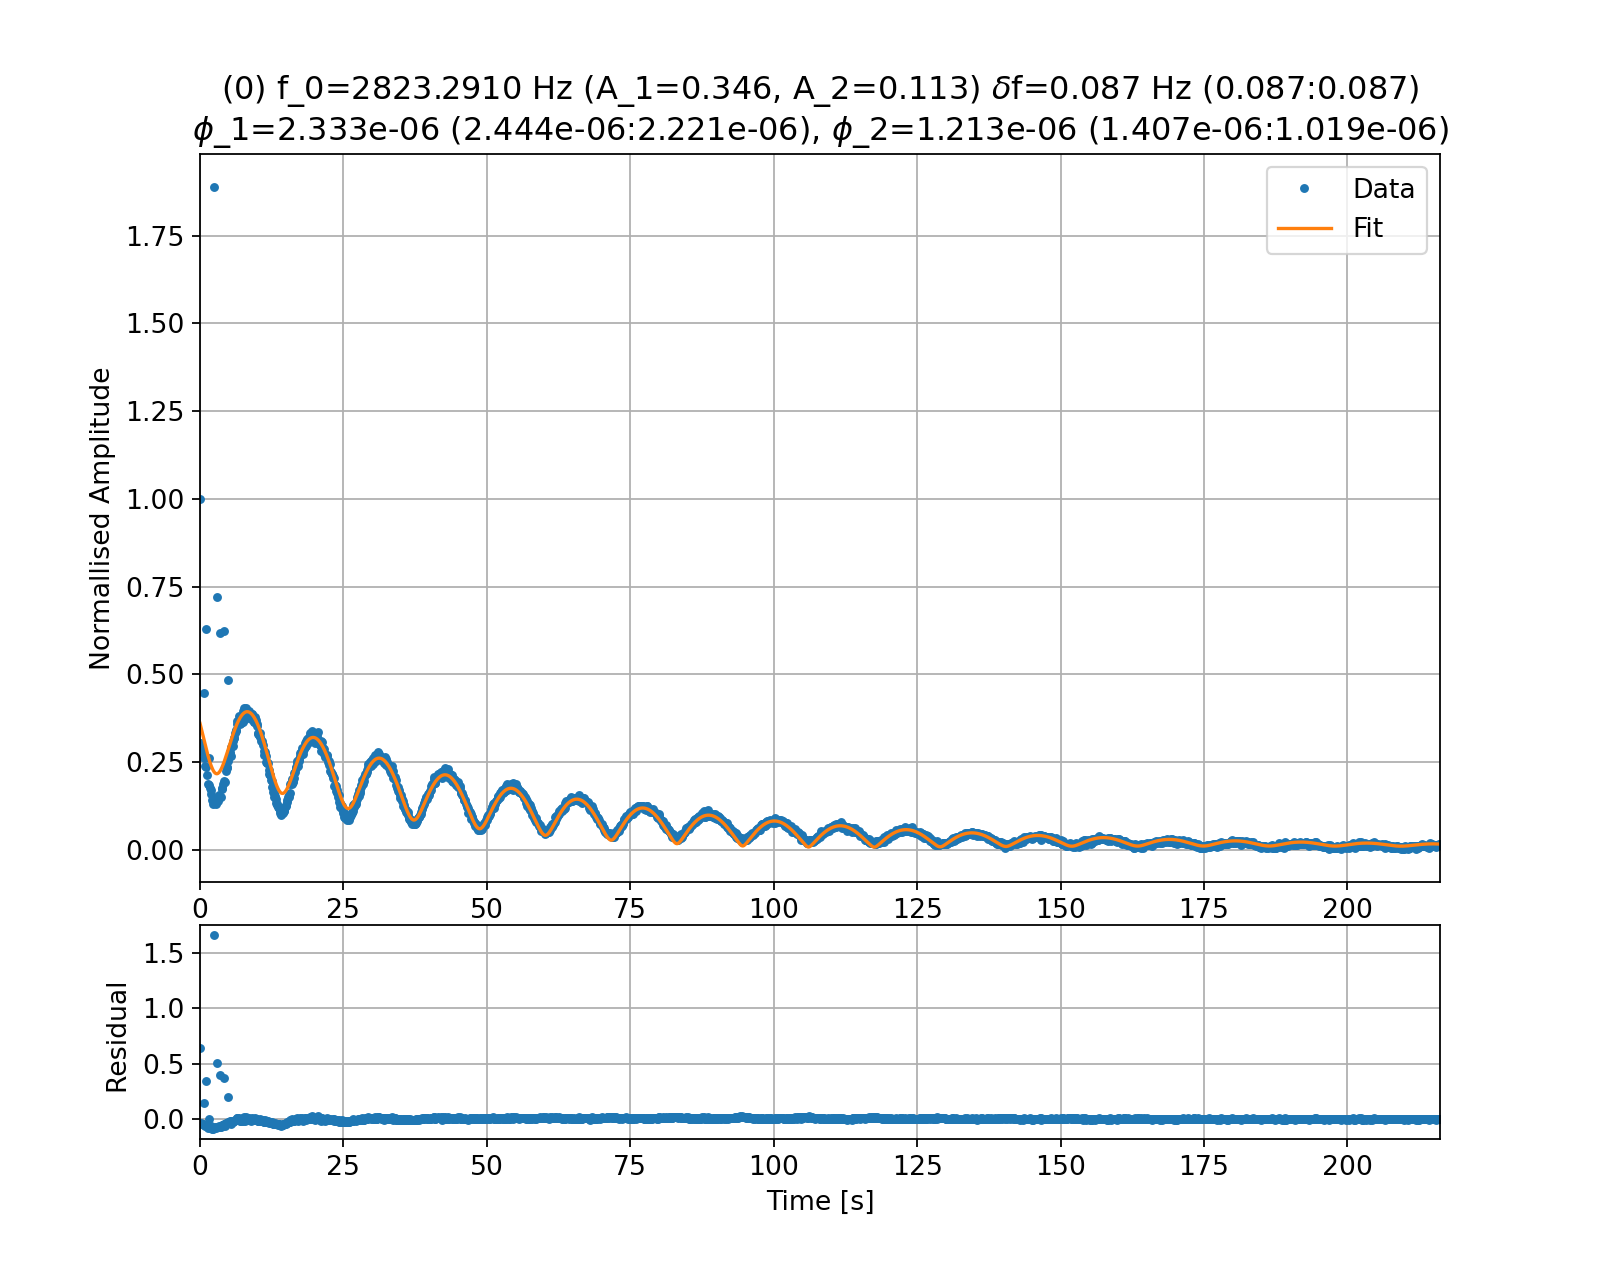

<IPython.core.display.Javascript object>


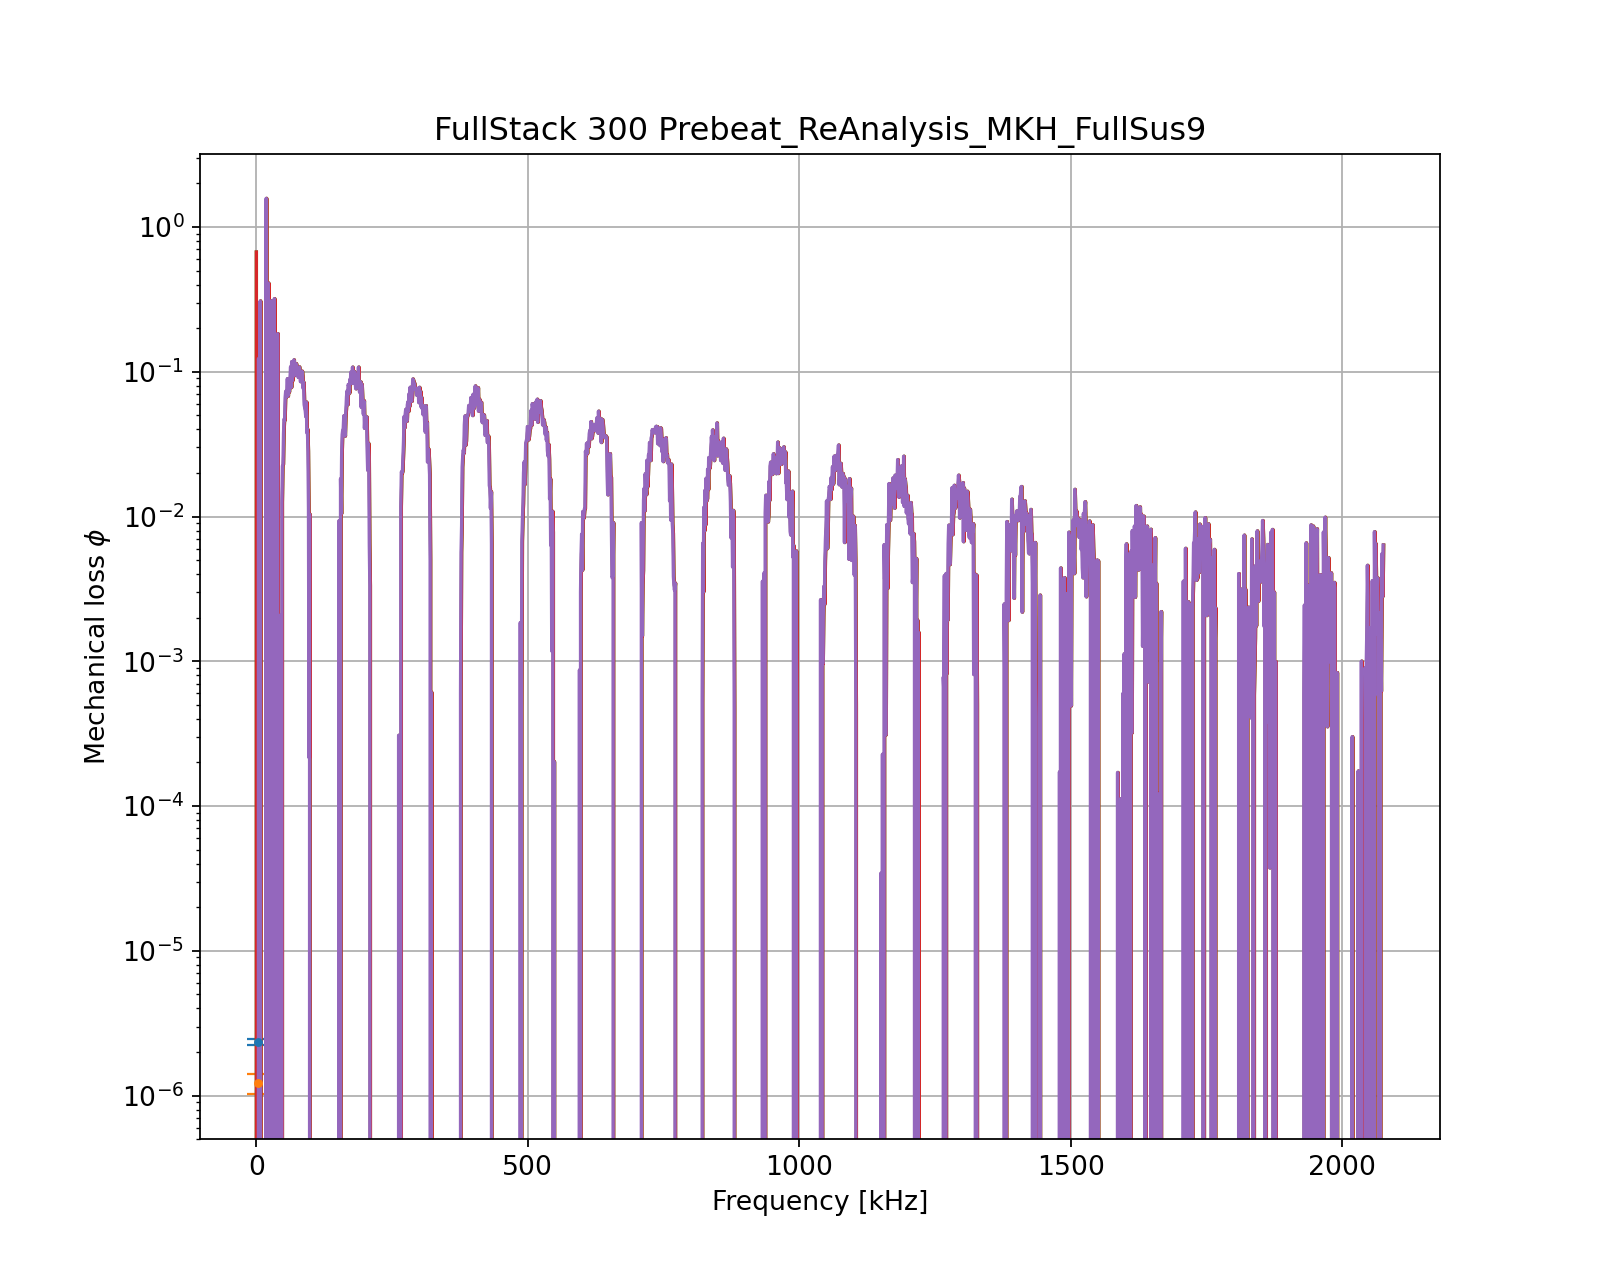

In [11]:
freqs,q,q_ci,df,df_ci,aa_buffered = fit_ringdowns_degenerate_st(prefix, makeplot=True, verbose=False) 
